<br> <img src="https://serea2017.uniandes.edu.co/images/Logo.png" height="80" width="150" align="Center" /> <br>

## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres:     
    Arturo Guerrero            (201823464)
    Carlos Andres Paez Rojas   (201924257)

**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

In [1]:
import numpy as np
import keras
from keras import layers
from keras.models import load_model, Sequential

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tensorflow.keras import regularizers
from keras.optimizers import SGD
from keras.layers import Dropout


Using TensorFlow backend.
G:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
G:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
G:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
G:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [16]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [26]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [27]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

#x_train = x_train[0:20]#
#y_train = y_train[0:20]#
#x_val = x_val[0:20]#
#y_val = y_val[0:20]#

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 secuencias de entrenamiento
25000 secuencias de validación


In [28]:
np.load = np_load_old

**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la priemra observación de entrenamiento:

In [29]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [30]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

Veamos el primer comentario de entrenamiento que es positivo:

In [31]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [32]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [49]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_41 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
        id_r = r
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 671s 54ms/step - loss: 0.4556 - acc: 0.7798 - val_loss: 0.3436 - val_acc: 0.8591
Epoch 2/3
12500/12500 [==============================] - 626s 50ms/step - loss: 0.2225 - acc: 0.9173 - val_loss: 0.3741 - val_acc: 0.8662
Epoch 3/3
12500/12500 [==============================] - 631s 50ms/step - loss: 0.1436 - acc: 0.9504 - val_loss: 0.4245 - val_acc: 0.8510
Desempeño (exactitud): accu_v1=0.851039999961853 , accu_v2=0.8422
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 655s 52ms/step - loss: 0.4116 - acc: 0.8220 - val_loss: 0.4260 - val_acc: 0.7939
Epoch 2/3
12500/12500 [==============================] - 605s 48ms/step - loss: 0.1981 - acc: 0.9247 - val_loss: 0.3249 - val_acc: 0.8770
Epoch 3/3
12500/12500 [==============================] - 608s 49ms/step - loss: 0.1061 - acc: 0.9643 - val_loss: 0.3429 - val_acc: 0.8884
Desemp

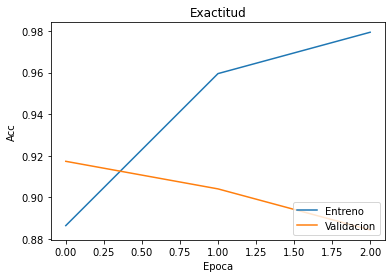

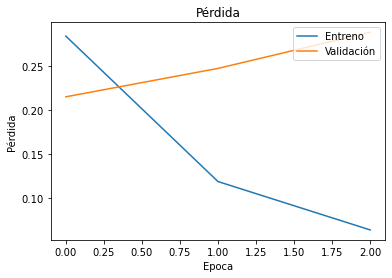

In [51]:
plt.figure(1)
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [52]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part='+str(id_r)+'.h5')

model_brnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_41 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [53]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11885   615]
 [ 1196 11304]]
Exactitud:  0.92756


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [54]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10827  1673]
 [ 2854  9646]]
Exactitud:  0.81892


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con esta red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

#### Realizamos la exploración con el uso de una red recurrente LSTM con 32 unidades. 

#### En adición probamos la configuración de la red variando el algoritmo de optimización entre **SGD**, **adam** y **rmsprop**

#### Por otro lado, variando el método de inicialización de la primera capa recurrente entre **He**, **Xavier** y **Normal**. 

#### Finalmente, variamos la función de activación de dicha capa usando **relu**, **sigmoid**, **selu** y **tanh**.

#### Definiendo parámetros del algoritmo de optimización y los inicializadores.

In [33]:
sgd = SGD(lr=0.01, momentum=0.001)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

initHe = keras.initializers.he_normal(seed=1)
initXavier = keras.initializers.glorot_normal(seed=1)
initNorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

#### Definición de función de definición de arquitectura de la red.

In [34]:
def modelo_1(opt, f_activation, init): 
    model_1_1 = Sequential()
    model_1_1.add(layers.Embedding(max_features, 128, input_length=maxlen))
    model_1_1.add(layers.LSTM(32, activation=f_activation, kernel_initializer=init, return_sequences=True))
    model_1_1.add(layers.LSTM(32))
    model_1_1.add(layers.Dense(1, activation='sigmoid'))
    model_1_1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model_1_1

#### Definición de la función de entrenamiento de la red.

In [35]:
def modelo_1_fit(model_1_1, string_model, err_p):
    flg = 0
    id_r = 0
    # Inicializamos la tabla donde guardamos los resultados
    x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

    # Definimos el número máximo de iteraciones (épocas de la red)
    epocas=3

    for i in range(0,3,1):
        r = i^3
        CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)

        # Ajustamos el modelo
        history=model_1_1.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)

        # Calculamos las metricas
        train_metrics = model_1_1.evaluate(x=CE_x, y=CE_y, verbose=0)
        valid_metrics = model_1_1.evaluate(x=CV_x, y=CV_y, verbose=0)
        test_metrics = model_1_1.evaluate(x=x_val, y=y_val, verbose=0)

        # Guardamos las métricas de desempeño
        accu_e = train_metrics[1]
        loss_e = train_metrics[0]
        accu_v = valid_metrics[1]
        loss_v = valid_metrics[0]
        accu_p = test_metrics[1]
        loss_p = test_metrics[0]

        if (loss_p < err_p):
            pathr =('RNN_'+string_model+'part='+str(r)+'.h5')
            model_1_1.save(pathr) 
            err_p = loss_p
            id_r = r
            flg = 1

        # Imprimimos el desempeño para cada repetición
        print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))

        x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

    print(x)
    
    return flg, id_r, err_p

#### Procedimiento de ciclos anidados para definir y entrenar cada red.

In [36]:
opt_s = 'sgd', 'adam', 'rmsprop'
init_s = 'initHe', 'initXavier', 'initNorm'
opt = sgd, adam, rmsprop
f_activation='relu', 'sigmoid', 'selu', 'tanh'
init = initHe, initXavier, initNorm 
ii = 0
jj = 0
kk = 0
# Inicializamos el error 
err_p = 999
for i in opt:
    for j in f_activation:
        for k in init:
            model_1_1 = modelo_1(i, j, k)
            string_model = opt_s[ii] +'_'+ f_activation[jj] +'_'+ init_s[kk]+'_'
            print(string_model)
            if ii == 0 and jj == 0 and kk == 0:
                param = string_model
                id_r = 3
            print(err_p)
            flg, id_r_metodo, err_p_metodo = modelo_1_fit(model_1_1, string_model, err_p)
            print(err_p_metodo)
            if flg == 1:
                param = string_model
                id_r = id_r_metodo
            err_p = err_p_metodo
            kk = kk + 1
        kk = 0
        jj = jj + 1
    jj = 0
    ii = ii + 1

sgd_relu_initHe_
999
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 233s 19ms/step - loss: 0.6932 - acc: 0.5023 - val_loss: 0.6932 - val_acc: 0.4958
Epoch 2/3
12500/12500 [==============================] - 232s 19ms/step - loss: 0.6931 - acc: 0.5042 - val_loss: 0.6931 - val_acc: 0.4987
Epoch 3/3
12500/12500 [==============================] - 234s 19ms/step - loss: 0.6930 - acc: 0.5077 - val_loss: 0.6930 - val_acc: 0.5013
Desempeño (exactitud): accu_v1=0.5012800000095368 , accu_v2=0.506
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 204s 16ms/step - loss: 0.6930 - acc: 0.5093 - val_loss: 0.6928 - val_acc: 0.5195
Epoch 2/3
12500/12500 [==============================] - 202s 16ms/step - loss: 0.6929 - acc: 0.5106 - val_loss: 0.6928 - val_acc: 0.5204
Epoch 3/3
12500/12500 [==============================] - 204s 16ms/step - loss: 0.6928 - acc: 0.5129 - val_loss: 0.6927 - v

In [37]:
print(param)
print(id_r)

rmsprop_selu_initNorm_
2


In [38]:
# RNN LSTM
model_rnn = load_model('RNN_'+param+'part='+str(id_r)+'.h5')                
#model_rnn = load_model('RNN_'+'rmsprop_selu_initHe_'+'part='+'2'+'.h5') 
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
lstm_67 (LSTM)               (None, 200, 32)           20608     
_________________________________________________________________
lstm_68 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 33        
Total params: 2,588,961
Trainable params: 2,588,961
Non-trainable params: 0
_________________________________________________________________


In [39]:
Y_predt = model_rnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_rnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11372  1128]
 [ 1550 10950]]
Exactitud:  0.89288


In [40]:
Y_predv = model_rnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_rnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10996  1504]
 [ 2310 10190]]
Exactitud:  0.84744


#### En total se evaluó el desempeño de 36 combinaciones de parámetros bajo la arquitectura definida, logrando los resultados anteriores.
Evaluamos la perdida de cada combinación en los datos de prueba:

> Bajo desempeño identificado usando una función de activación **relu**. Solución sin convergencia utilizando **adam** y **rsmprop**.

> El mejor desempeño usando el algoritmo de optimización **sgd** se logra con una función de activación **selu** e inicialización con **He**

> Seguidamente se identifica un mejor el desempeño usando el algoritmo de optimización **adam** y utilizando una función de activación **sigmoide**, finalmente el mejor desempeño logrado con **Adam** es usando la función de activación **tanh** e inicialización con **He**.

> Finalmente, el mejor desempeño logrado se obtiene usando el algoritmo de optimización **rmsprop**, función de activación **selu** e inicialización **Normal**.   

### Como resultado, se logra exactitud de **89.28%** y **84.74%** sobre datos de entrenamiento y prueba respectivamente.

#### En este orden, a la configuración de red con mejor desempeño incrementamos el numero de unidades a **128** sobre la primera capa recurrente, **64** unidades a la siguiente capa y adicionamos una función Dropout con tasa de aprendizaje **0.2** antes de la capa de salida. Y entrenamos la red incrementando a 5 épocas.

In [46]:
model_1_1 = Sequential()
model_1_1.add(layers.Embedding(max_features, 128, input_length=maxlen))
model_1_1.add(layers.LSTM(128, activation='selu', kernel_initializer=initNorm, return_sequences=True))
model_1_1.add(layers.LSTM(64))
model_1_1.add(Dropout(rate=0.2, seed=1))  
model_1_1.add(layers.Dense(1, activation='sigmoid'))
model_1_1.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [47]:
model_1_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
lstm_80 (LSTM)               (None, 200, 128)          131584    
_________________________________________________________________
lstm_81 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 2,741,057
Trainable params: 2,741,057
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=5

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
             
    # Ajustamos el modelo
    history=model_1_1.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model_1_1.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_1_1.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_1_1.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('RNN_Reg_Drop_part='+str(r)+'.h5')
        model_1_1.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Train on 12500 samples, validate on 12500 samples
Epoch 1/5
12500/12500 [==============================] - 1051s 84ms/step - loss: 0.5333 - acc: 0.7294 - val_loss: 0.4956 - val_acc: 0.7840
Epoch 2/5
12500/12500 [==============================] - 1039s 83ms/step - loss: 0.3187 - acc: 0.8748 - val_loss: 0.5235 - val_acc: 0.7935
Epoch 3/5
12500/12500 [==============================] - 1027s 82ms/step - loss: 0.2414 - acc: 0.9119 - val_loss: 0.3669 - val_acc: 0.8675
Epoch 4/5
12500/12500 [==============================] - 1018s 81ms/step - loss: 0.1746 - acc: 0.9394 - val_loss: 0.5278 - val_acc: 0.8241
Epoch 5/5
12500/12500 [==============================] - 1014s 81ms/step - loss: nan - acc: 0.0042 - val_loss: nan - val_acc: 0.0000e+00
Desempeño (exactitud): accu_v1=0.0 , accu_v2=0.0
Train on 12500 samples, validate on 12500 samples
Epoch 1/5
12500/12500 [==============================] - 1163s 93ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 2/5
12500/1

##### Resultados no favorables, algoritmo sin convergencia. 

## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

#### Con el objetivo de mejorar los resultados, exploramos el uso de una red recurrente GRU, con 64 unidades y utilizando como parámetros los identificados anteriormente con mejor desempeño: Algoritmo de optimización: rmsprop. Función de activación: selu e inicializador: Normal.

In [56]:
model_1_2 = Sequential()
model_1_2.add(layers.Embedding(max_features, 128, input_length=maxlen))
model_1_2.add(layers.GRU(64, activation='selu', kernel_initializer=initNorm, return_sequences=True))
model_1_2.add(layers.GRU(64))
model_1_2.add(layers.Dense(1, activation='sigmoid'))
model_1_2.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

model_1_2.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 64)           37056     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 2,621,889
Trainable params: 2,621,889
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
             
    # Ajustamos el modelo
    history=model_1_2.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model_1_2.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_1_2.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_1_2.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('RNN_GRU_part='+str(r)+'.h5')
        model_1_2.save(pathr) 
        err_p = loss_p
        id_r = r
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 272s 22ms/step - loss: 0.4762 - acc: 0.7801 - val_loss: 0.3948 - val_acc: 0.8248
Epoch 2/3
12500/12500 [==============================] - 286s 23ms/step - loss: 0.2808 - acc: 0.8926 - val_loss: 0.7454 - val_acc: 0.7761
Epoch 3/3
12500/12500 [==============================] - 293s 23ms/step - loss: 0.2033 - acc: 0.9282 - val_loss: 0.3258 - val_acc: 0.8754
Desempeño (exactitud): accu_v1=0.87544 , accu_v2=0.85688
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 295s 24ms/step - loss: 0.2314 - acc: 0.9106 - val_loss: 0.2390 - val_acc: 0.9110
Epoch 2/3
12500/12500 [==============================] - 299s 24ms/step - loss: 0.1534 - acc: 0.9455 - val_loss: 0.3342 - val_acc: 0.8915
Epoch 3/3
12500/12500 [==============================] - 298s 24ms/step - loss: 0.1062 - acc: 0.9638 - val_loss: 0.3737 - val_acc: 0.8920
Desempeño (exac

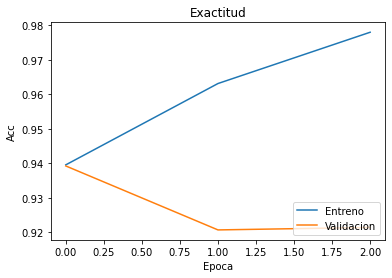

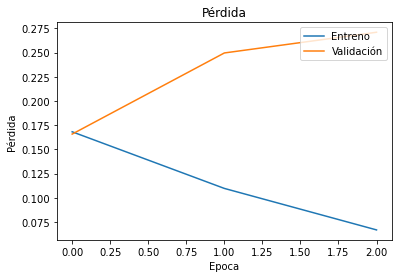

In [58]:
plt.figure(1)
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [59]:
# RNN GRU
model_rnn_gru = load_model('RNN_GRU_part='+str(id_r)+'.h5')

model_rnn_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 64)           37056     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 2,621,889
Trainable params: 2,621,889
Non-trainable params: 0
_________________________________________________________________


In [60]:
Y_predt = model_rnn_gru.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_rnn_gru.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11828   672]
 [ 1398 11102]]
Exactitud:  0.9172


In [61]:
Y_predv = model_rnn_gru.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_rnn_gru.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[11420  1080]
 [ 2498 10002]]
Exactitud:  0.85688


### Como resultado, logramos mejorar el desempeño anterior, se logra exactitud de **91.72%** y **85.68%** sobre datos de entrenamiento y prueba respectivamente.

#### Finalmente, a la arquitectura de red anterior, modificamos las dos capas GRU adicionando una capa bidireccional. 

In [62]:
model_1_2 = Sequential()
model_1_2.add(layers.Embedding(max_features, 128, input_length=maxlen))
model_1_2.add(layers.Bidirectional(layers.GRU(64, activation='selu', kernel_initializer=initNorm, return_sequences=True)))
model_1_2.add(layers.Bidirectional(layers.GRU(64)))
model_1_2.add(layers.Dense(1, activation='sigmoid'))
model_1_2.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

model_1_2.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 128)          74112     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               74112     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 129       
Total params: 2,708,353
Trainable params: 2,708,353
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
             
    # Ajustamos el modelo
    history=model_1_2.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model_1_2.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_1_2.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_1_2.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_GRU_part='+str(r)+'.h5')
        model_1_2.save(pathr) 
        err_p = loss_p
        id_r = r
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 629s 50ms/step - loss: 0.4627 - acc: 0.7786 - val_loss: 0.3384 - val_acc: 0.8573
Epoch 2/3
12500/12500 [==============================] - 591s 47ms/step - loss: 0.2712 - acc: 0.8959 - val_loss: 0.4464 - val_acc: 0.7844
Epoch 3/3
12500/12500 [==============================] - 603s 48ms/step - loss: 0.2107 - acc: 0.9193 - val_loss: 0.3009 - val_acc: 0.8746
Desempeño (exactitud): accu_v1=0.874640000038147 , accu_v2=0.86372
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 619s 50ms/step - loss: 0.2368 - acc: 0.9074 - val_loss: 0.2532 - val_acc: 0.8962
Epoch 2/3
12500/12500 [==============================] - 621s 50ms/step - loss: 0.1665 - acc: 0.9367 - val_loss: 0.3348 - val_acc: 0.8743
Epoch 3/3
12500/12500 [==============================] - 620s 50ms/step - loss: 0.1214 - acc: 0.9581 - val_loss: 0.3652 - val_acc: 0.8872
Desem

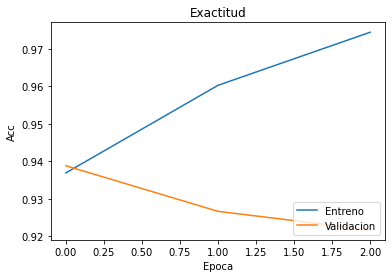

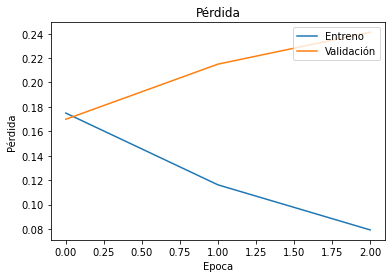

In [64]:
plt.figure(1)
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [65]:
# BRNN GRU
model_brnn_gru = load_model('BRNN_GRU_part='+str(id_r)+'.h5')

model_brnn_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 128)          74112     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               74112     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 129       
Total params: 2,708,353
Trainable params: 2,708,353
Non-trainable params: 0
_________________________________________________________________


In [66]:
Y_predt = model_brnn_gru.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn_gru.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[10947  1553]
 [  618 11882]]
Exactitud:  0.91316


In [67]:
Y_predv = model_brnn_gru.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn_gru.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10160  2340]
 [ 1067 11433]]
Exactitud:  0.86372


###  Excelente resultado, logramos mejorar nuevamente el desempeño anterior, se logra exactitud de **91.31%** y **86.37%** sobre datos de entrenamiento y prueba respectivamente.

#### Finalmente, como recomendaciones siguientes, probaríamos modificando la arquitectura de la red adicionando algunas capas bidireccionales GRU, modificando diferente cantidad de unidades en cada capa. 